In [158]:
import os
import math
import warnings 
warnings.filterwarnings("ignore")

from datasets import load_dataset
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          AutoConfig)
from transformers import LlamaConfig
from transformers import LlamaForCausalLM
from transformers import LlamaTokenizer
from transformers import TextStreamer

import torch 
def fix_torch_seed(seed = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()

# Helper Function

In [159]:
def format_large_number(n):
    """
    Formats a large number into a human-readable string (e.g., 1.2M, 3.4B).
    """
    if n == 0:
        return '0'
    
    n = float(n)
    # Define magnitude suffixes
    magnitudes = ['', ' Thousand', ' M', ' B', ' T']
    # Calculate the index of the appropriate magnitude
    millidx = max(0, min(len(magnitudes) - 1, int(math.floor(math.log10(abs(n)) / 3))))
    
    # Format the number to one decimal place and append the suffix
    return '{:.1f}{}'.format(n / 10**(3 * millidx), magnitudes[millidx]).strip()

In [59]:
from getpass import getpass

os.environ["HF_TOKEN"] = getpass("Enter API Key : ")

In [160]:
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Version: {torch.version.cuda}")

device = "cuda" if torch.cuda.is_available() else "cpu"

GPU Name: Tesla T4
GPU Version: 12.6


# 1. Model Configuration

In [21]:
config = LlamaConfig()
print(config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.3",
  "use_cache": true,
  "vocab_size": 32000
}



In [22]:
# Next, update parameters to change the model architecture
config.num_hidden_layers = 12
config.hidden_size = 1024
config.intermediate_size = 4096
config.num_key_value_heads = 8
config.torch_dtype = "bfloat16"
config.use_cache = False
print(config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.3",
  "use_cache": false,
  "vocab_size": 32000
}



# 2 Weight Initialization

We have different ways of initializing weights of a model for training

- Random Weight Initialization
- Using an existing model for continued pre-training
- Downscaling an existing model
- Upscaling an existing model

## 2.1 Random Weight Initialization 

Randomly initializing model weights sets all weights to values from a truncated normal distribution with mean 0 and standard deviation 0.02. Values beyond 2-sigma from the mean are set to 0.

In [28]:
model = LlamaForCausalLM(config).to(device)
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-11): 12 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=1024, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((1024,), eps=1e-06)
    (r

In [ ]:
# "numel" this function calculates the product of all dimensions of a tensor, effectively providing its total size regardless of its shape or dimensionality'
def print_nparams(model):
    total_params = 0
    for p in model.parameters():
        total_params += p.numel()
    
    print(f"The total number of parameters is : {total_params}")


print_nparams(model)
# We see that's a lot parameters to train 

The total number of parameters is : 342385664


In [ ]:
# First we will load the pretrained Llama Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "huggyllama/llama-7b"
)

input_ids = tokenizer("What is the most complicated maths topics?", 
                        return_tensors = "pt").to(device)

# Streamer 
streamer = TextStreamer(
    tokenizer, 
    skip_prompt = True, 
    skip_special_tokens = True
)


# Generate the output from the model
outputs = model.generate(
    **input_ids, 
    streamer = streamer, 
    use_cache = True, 
    max_new_tokens = 128, 
    do_sample = False
)

# Some gubrish has generated the output, through this we can understand that we have to training the model for longer time to get the better language understanding

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


ा epleepleep alk alkleepleepleep alk alk alk teams });teamsweetााााा Items Items Items Items Items Items Itemsाा Items Items Itemsाााा Itemsा Items Items Items Items Items Items Items Itemsाााााा Items Items Items Items Items Items Items Items Musicalionali Musicalionali Musicalionali Musicalionali Musicalionali Musicalionali Musicalionali Musicalionali Musicalionali Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## Musical## назна## назна## назна назна назна назна назна назна назна


In [38]:
import gc
del model
del streamer
del outputs
gc.collect()

383

## 2.2Reuse general pretrained model weights

In [44]:
model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b", 
    dtype = torch.bfloat16, 
    device_map = "auto",
)

tokenizer = AutoTokenizer.from_pretrained(
    "huggyllama/llama-7b"
)

# Input Ids to the tokenizer
input_ids = tokenizer("What are the most complicated maths?", return_tensors = "pt").to(device)

# Define Streamer 
streamer = TextStreamer(
    tokenizer, 
    skip_prompt = True, 
    skip_special_tokens = True
)

outputs = model.generate(**input_ids, 
                streamer = streamer, 
                use_cache= True, 
                max_new_tokens = 128,
                do_sample = False)

# we can see the model is clearly with the english language, it can generate the content related to the question.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


I'm not a mathematician, but I'm interested in maths. I'm interested in the most complicated maths.
I'm not interested in the most complicated maths that is used in everyday life, like the maths used in a computer. I'm interested in the most complicated maths that is used 

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 6440 has 14.74 GiB memory in use. Of the allocated memory 13.88 GiB is allocated by PyTorch, and 754.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

We have exhausted all the memory by loading the 7b parameters model

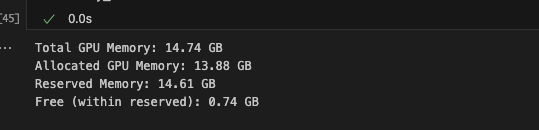

In [ ]:
import gc
del model
del streamer
del outputs
gc.collect()

5131

In [55]:
def memory_info():
    " Function to check the total memory available"
    total_memory = torch.cuda.get_device_properties(device).total_memory # Total memory of the GPUs
    allocated_memory = torch.cuda.memory_allocated(device) # currently allocated memory by tensors
    reserved_memory = torch.cuda.memory_reserved(device) # memory reserved by the caching allocator 

    # Free memory (within reserved)
    free_mem = reserved_memory - allocated_memory

    print(f"Total GPU Memory: {total_memory/ 1024**3:.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / 1024**3:.2f} GB")
    print(f"Reserved Memory: {reserved_memory / 1024**3:.2f} GB")
    print(f"Free (within reserved): {free_mem / 1024**3:.2f} GB")

memory_info()

Total GPU Memory: 14.74 GB
Allocated GPU Memory: 0.01 GB
Reserved Memory: 14.61 GB
Free (within reserved): 14.61 GB


## 2.3 Downscaling from a general pretrained model

Downscaling the model we are gonna few layers. Let's see how we are gonna drop few of the layers from the original model



In [103]:
# lets load a one billion llama model
model = AutoModelForCausalLM.from_pretrained('meta-llama/llama-3.2-1B',
                                            device_map = "auto",
                                            torch_dtype = "bfloat16"
                                            )                                       

In [89]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/llama-3.2-1B"
)

# Input Ids to the tokenizer
input_ids = tokenizer("What is the most complicated maths?", return_tensors = "pt").to(device)

# Define Streamer 
streamer = TextStreamer(
    tokenizer, 
    skip_prompt = True, 
    skip_special_tokens = True
)

outputs = model.generate(**input_ids, 
                streamer = streamer, 
                use_cache= True, 
                max_new_tokens = 128,
                do_sample = False)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 The answer is: it depends. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most complicated maths is the maths that is used to describe the most complicated things. The most


In [90]:
print(model)

print_nparams(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

In [95]:
memory_info()

Total GPU Memory: 14.74 GB
Allocated GPU Memory: 4.61 GB
Reserved Memory: 14.61 GB
Free (within reserved): 10.00 GB


After downscaling the model

In [104]:
layers = model.model.layers

# We are having 16 llamaDecoder layers, we are using only 10 layers for pretraining, first 5 and last 5 layers
model.model.layers = layers[:5] + layers[-5:]

# Updating the config 
config = AutoConfig.from_pretrained(
    'meta-llama/llama-3.2-1B', 
    num_hidden_layers = len(model.model.layers)
)

# set the new config to the model 
model.config = config

print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-9): 10 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rot

In [105]:
# Downscaling model : num of params
print_nparams(model)

print(f"The number of parameters excluded during downscaling : {format_large_number(1235814400-870885376)}")

The total number of parameters is : 870885376
The number of parameters excluded during downscaling : 364.9 M


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/llama-3.2-1B"
)

# Input Ids to the tokenizer
input_ids = tokenizer("What is the most complicated maths?", return_tensors = "pt").to(device)

# Define Streamer 
streamer = TextStreamer(
    tokenizer, 
    skip_prompt = True, 
    skip_special_tokens = True
)

outputs = model.generate(**input_ids, 
                streamer = streamer, 
                use_cache= False, # make sure to set this as False because we are using the downscale model and it will throw error if we set it to True
                max_new_tokens = 128,
                do_sample = False)

# Again we are getting the output, but it doesn't make any sense, so training is required for the model to make sense

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 The video is being, fact to get, not the right on the right the 1. 5. The 5-1, the 1. 5. 1. 6. and 5. and 1. 7. 1. 1. 1. 3. 3, the 1s 1 1 is a factor of 1 and 1 will I and 1 will 1 I, 1 1 I, 1 1 1 1 1 1 1 1 1 1 1 1 1 1


In [117]:
memory_info()

Total GPU Memory: 14.74 GB
Allocated GPU Memory: 4.61 GB
Reserved Memory: 14.61 GB
Free (within reserved): 10.00 GB


## 2.4 Upscaling the Model

Here, we are going to upscale the llama 16 layers to 20 layers. Here are the steps we are going to follow

1. Configure a 20 layer model and initialize it with random weights
2. Load the 16 layer model into memory_info
3. Copy the bottom 10 layers and top 10 layers from the 16 layer model and use them to overwrite the random weights of the 20 layer model
4. Copy over the embedding and classifying layers to replace the randomly initialized counterparts in the 20 layer model

In [161]:
config = LlamaConfig(
    num_hidden_layers = 16, 
    hidden_size = 2048, 
    intermediate_size = 8192,
    num_attention_heads = 32, 
    num_key_val_heads = 8,
    torch_dtype = "bfloat16", 
    use_cache = False
)

print(config)


LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_val_heads": 8,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.3",
  "use_cache": false,
  "vocab_size": 32000
}



In [162]:
# Step -1 Configure over 20 layer model with randomly initialized weights
model = LlamaForCausalLM(config)
model = model.to(dtype = torch.bfloat16)
print(model)
print_nparams(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-06)
    (r

In [163]:
# load pretrained llama -1B million
pretrained_model = AutoModelForCausalLM.from_pretrained('meta-llama/llama-3.2-1B', 
                                        device_map= "auto", 
                                        torch_dtype = torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained('meta-llama/llama-3.2-1B')

print_nparams(pretrained_model)

The total number of parameters is : 1235814400


In [164]:
# Now, we copy the weights from the pretrained model and overwrite the randomly generated weight in our custom configuration
from copy import deepcopy

model.model.layers = deepcopy(pretrained_model.model.layers[:-6]) + deepcopy(pretrained_model.model.layers[6:])

# Embedding layer
model.model.embed_tokens = deepcopy(pretrained_model.model.embed_tokens)

# lm head
model.lm_head = deepcopy(pretrained_model.lm_head)

print(model.config)


LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_val_heads": 8,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.3",
  "use_cache": false,
  "vocab_size": 32000
}



In [165]:
print_nparams(model)
print("formatted number :", format_large_number(1741767680))

The total number of parameters is : 1741768704
formatted number : 1.7 B


In [167]:
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-19): 20 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-06)
    (ro

In [168]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/llama-3.2-1B"
)

# Input Ids to the tokenizer
input_ids = tokenizer("What is the most complicated maths?", return_tensors = "pt").to(device)

# Define Streamer 
streamer = TextStreamer(
    tokenizer, 
    skip_prompt = True, 
    skip_special_tokens = True
)

outputs = model.generate(**input_ids, 
                streamer = streamer, 
                use_cache= False, # make sure to set this as False because we are using the downscale model and it will throw error if we set it to True
                max_new_tokens = 128,
                do_sample = False)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths maths­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i­i


# Save this model to the HuggingFace hub

In [ ]:
model.push_to_hub("./PreTraining/llama_depth_upscaling")